# Assignment 1: From Dirty Data to Predictive Models

Federico Giorgi (fg2617)

Titanic Survival Dataset

## Dataset Description

**Data Dictionary**

| Variable  | Definition                          | Key                                  |
|-----------|-------------------------------------|--------------------------------------|
| survival  | Survival                            | 0 = No, 1 = Yes                      |
| pclass    | Ticket class                        | 1 = 1st, 2 = 2nd, 3 = 3rd            |
| sex       | Sex                                 |                                      |
| age       | Age in years                        |                                      |
| sibsp     | # of siblings / spouses aboard      |                                      |
| parch     | # of parents / children aboard      |                                      |
| ticket    | Ticket number                       |                                      |
| fare      | Passenger fare                      |                                      |
| cabin     | Cabin number                        |                                      |
| embarked  | Port of Embarkation                 | C = Cherbourg, Q = Queenstown, S = Southampton |


**Variable Notes**
pclass: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

## Basics

In [361]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.metrics import accuracy_score, classification_report, make_scorer, precision_score, recall_score, f1_score, mean_squared_error, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold, KFold, learning_curve, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.calibration import calibration_curve
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB


In [362]:
df_train = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")

## 1 Exploratory data analysis and visualization

In [363]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 1.1 Univariate Data Analysis

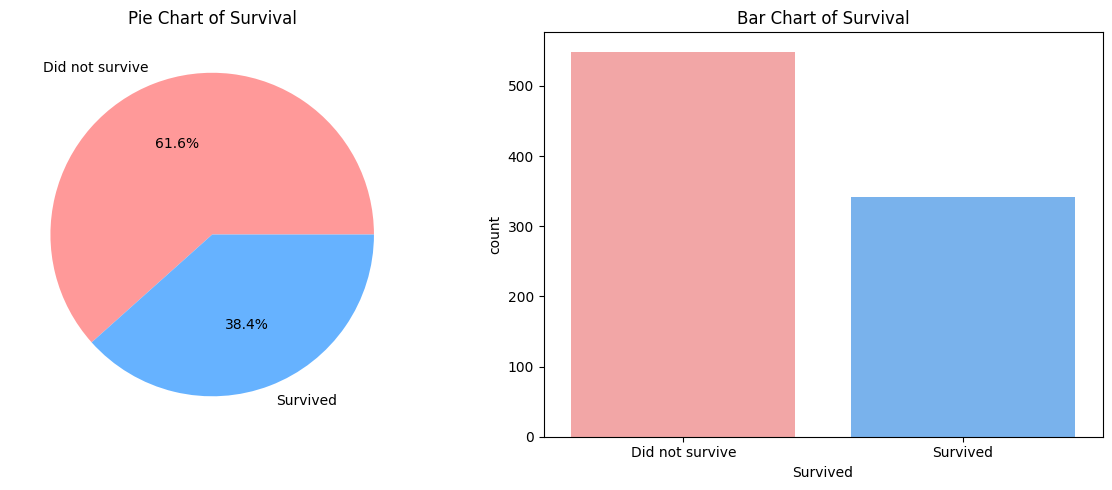

In [364]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart
df_train["Survived"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    labels=["Did not survive", "Survived"],
    colors=["#FF9999", "#66B2FF"],
    ax=axes[0]
)
axes[0].set_ylabel("")
axes[0].set_title("Pie Chart of Survival")

# Bar chart
sns.countplot(x="Survived", data=df_train, palette=["#FF9999", "#66B2FF"], ax=axes[1])
axes[1].set_xticklabels(["Did not survive", "Survived"])
axes[1].set_title("Bar Chart of Survival")

plt.tight_layout()
plt.show()

Both plots highlight a strong class imbalance in the dataset: most passengers did not survive, while survivors represent a much smaller portion.

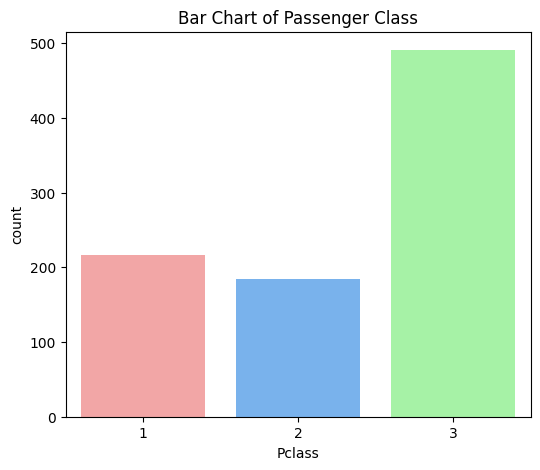

In [365]:
plt.figure(figsize=(6, 5))
sns.countplot(x="Pclass", data=df_train, palette=["#FF9999", "#66B2FF", "#99FF99"])
plt.title("Bar Chart of Passenger Class")
plt.show()

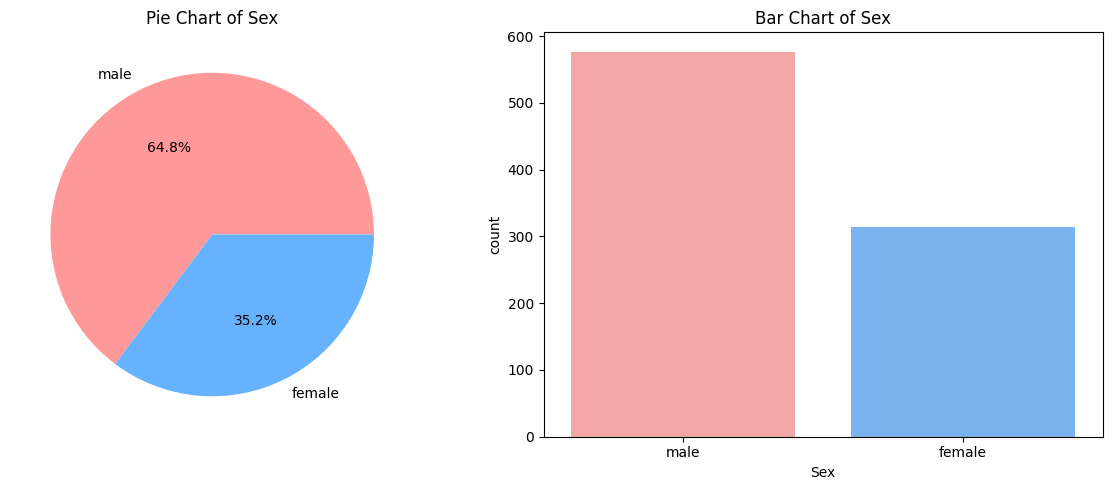

In [366]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df_train["Sex"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    colors=["#FF9999", "#66B2FF"],
    ax=axes[0]
)
axes[0].set_ylabel("")
axes[0].set_title("Pie Chart of Sex")

sns.countplot(x="Sex", data=df_train, palette=["#FF9999", "#66B2FF"], ax=axes[1])
axes[1].set_title("Bar Chart of Sex")

plt.tight_layout()
plt.show()

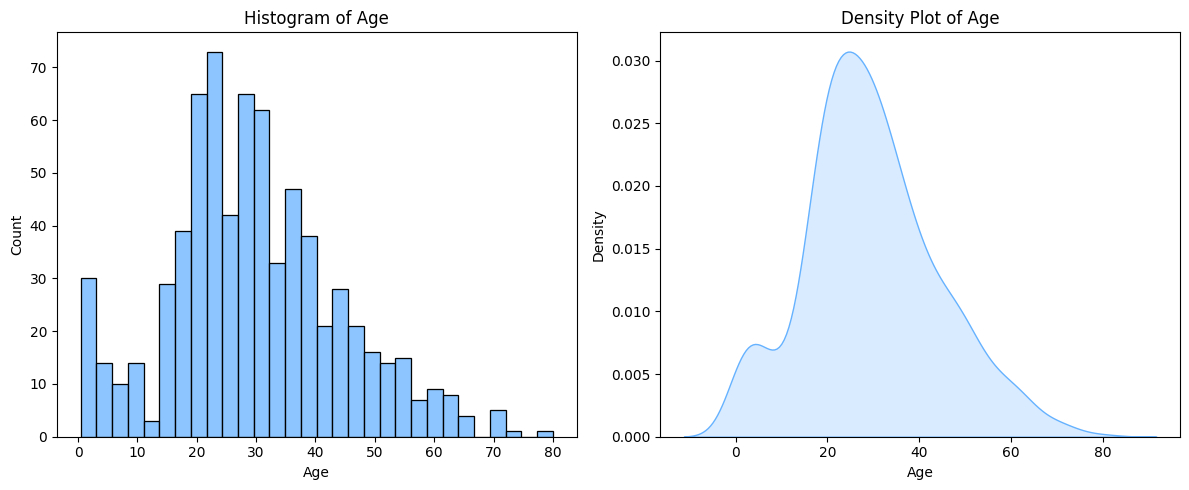

In [367]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_train["Age"].dropna(), bins=30, kde=False, color="#66B2FF", ax=axes[0])
axes[0].set_title("Histogram of Age")

sns.kdeplot(df_train["Age"].dropna(), fill=True, color="#66B2FF", ax=axes[1])
axes[1].set_title("Density Plot of Age")

plt.tight_layout()
plt.show()

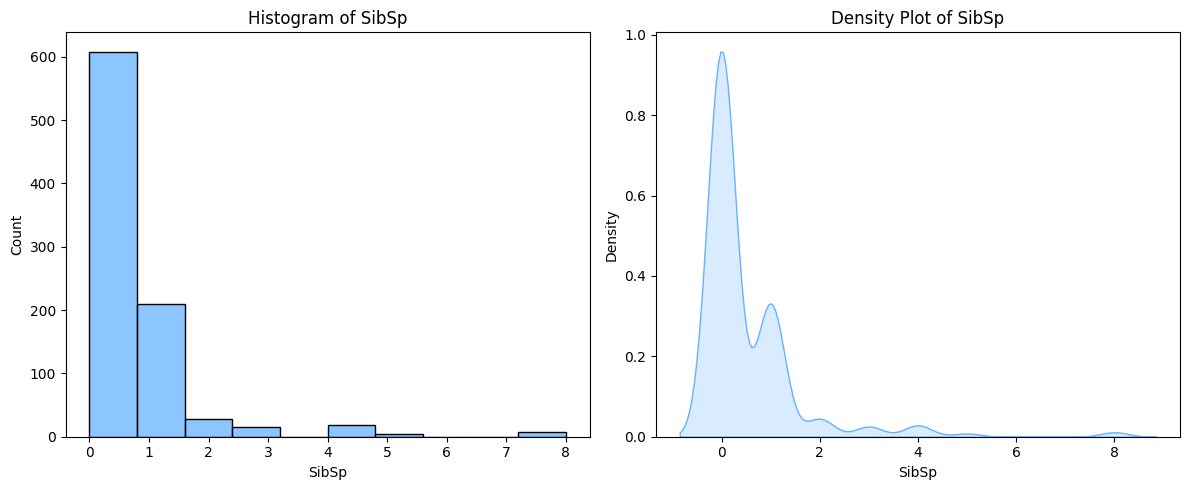

In [368]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_train["SibSp"], bins=10, kde=False, color="#66B2FF", ax=axes[0])
axes[0].set_title("Histogram of SibSp")

sns.kdeplot(df_train["SibSp"], fill=True, color="#66B2FF", ax=axes[1])
axes[1].set_title("Density Plot of SibSp")

plt.tight_layout()
plt.show()

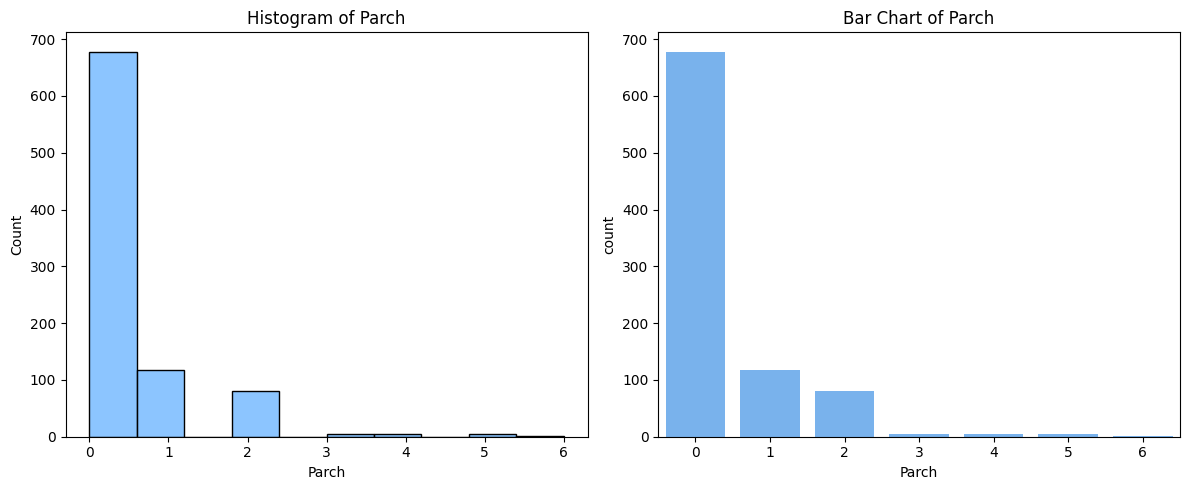

In [369]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_train["Parch"], bins=10, kde=False, color="#66B2FF", ax=axes[0])
axes[0].set_title("Histogram of Parch")

sns.countplot(x="Parch", data=df_train, color="#66B2FF", ax=axes[1])
axes[1].set_title("Bar Chart of Parch")

plt.tight_layout()
plt.show()

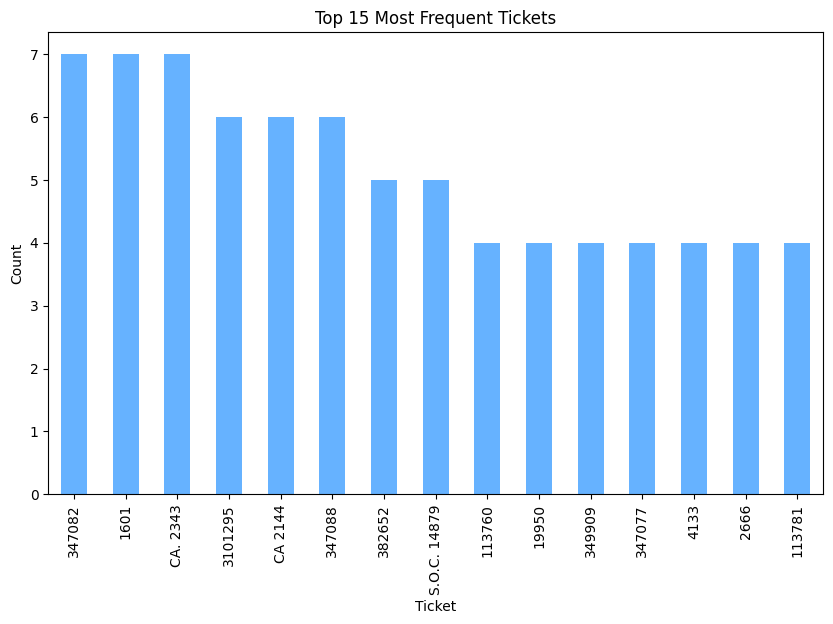

In [370]:
plt.figure(figsize=(10, 6))
df_train["Ticket"].value_counts().head(15).plot(kind="bar", color="#66B2FF")
plt.title("Top 15 Most Frequent Tickets")
plt.xlabel("Ticket")
plt.ylabel("Count")
plt.show()


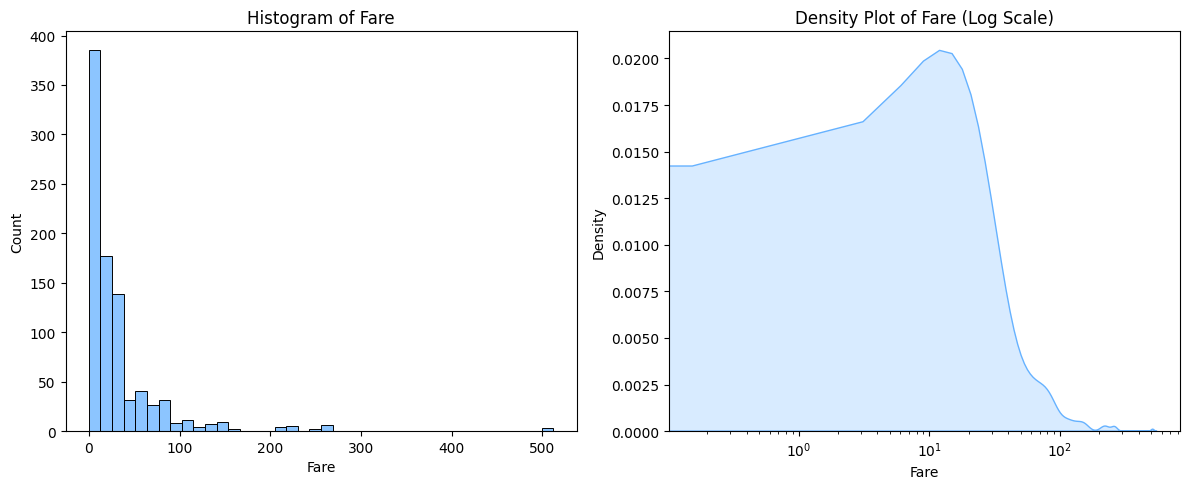

In [371]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_train["Fare"], bins=40, kde=False, color="#66B2FF", ax=axes[0])
axes[0].set_title("Histogram of Fare")

sns.kdeplot(df_train["Fare"], fill=True, color="#66B2FF", ax=axes[1])
axes[1].set_xscale("log")
axes[1].set_title("Density Plot of Fare (Log Scale)")

plt.tight_layout()
plt.show()

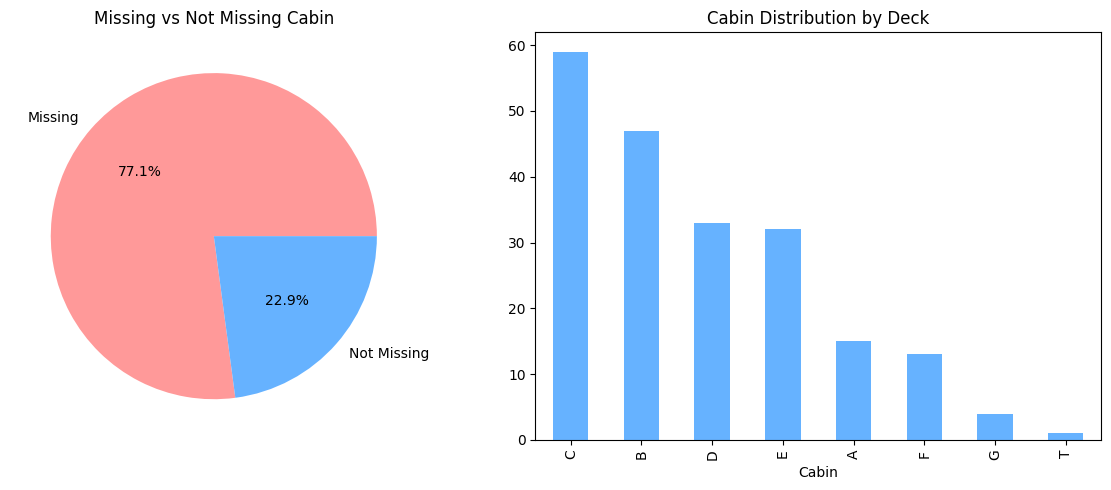

In [372]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df_train["Cabin"].isnull().value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    labels=["Missing", "Not Missing"],
    colors=["#FF9999", "#66B2FF"],
    ax=axes[0]
)
axes[0].set_ylabel("")
axes[0].set_title("Missing vs Not Missing Cabin")

df_train["Cabin"].dropna().str[0].value_counts().plot(kind="bar", color="#66B2FF", ax=axes[1])
axes[1].set_title("Cabin Distribution by Deck")

plt.tight_layout()
plt.show()

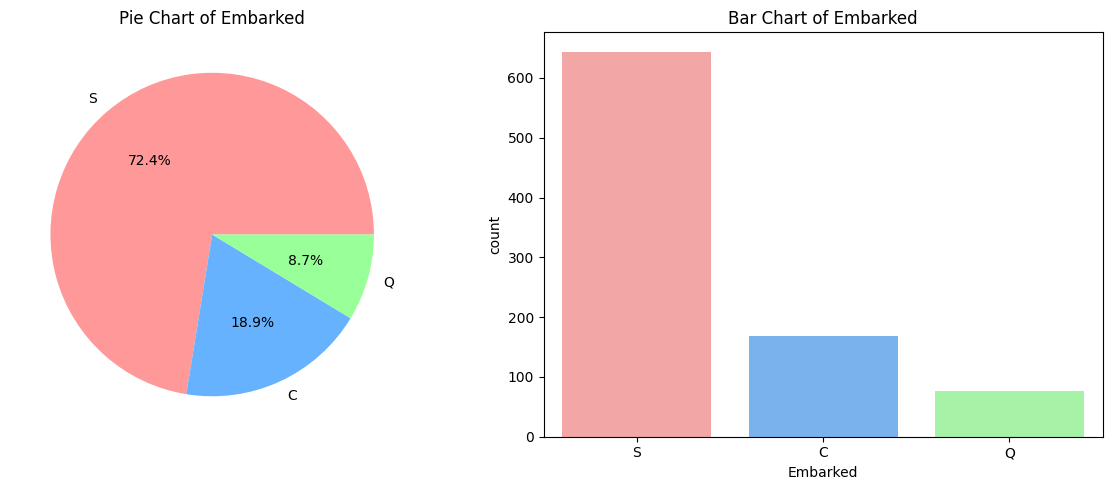

In [373]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df_train["Embarked"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    colors=["#FF9999", "#66B2FF", "#99FF99"],
    ax=axes[0]
)
axes[0].set_ylabel("")
axes[0].set_title("Pie Chart of Embarked")

sns.countplot(x="Embarked", data=df_train, palette=["#FF9999", "#66B2FF", "#99FF99"], ax=axes[1])
axes[1].set_title("Bar Chart of Embarked")

plt.tight_layout()
plt.show()


### 1.2 Multivariate Data Analysis

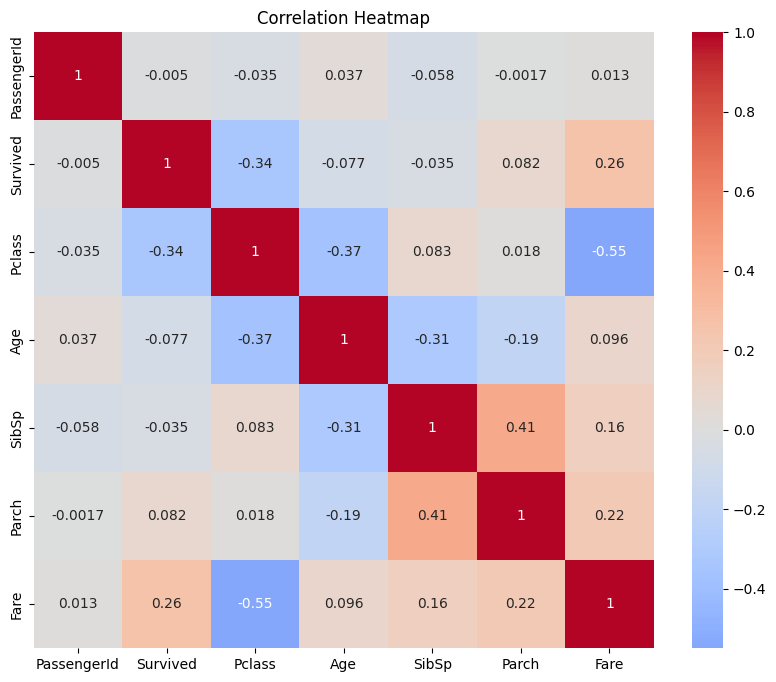

In [374]:
plt.figure(figsize=(10, 8))
corr = df_train.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

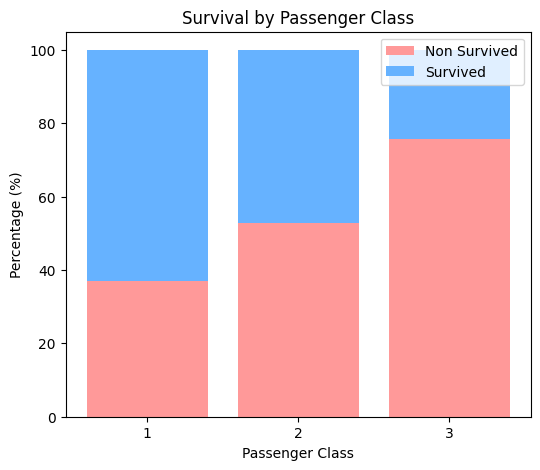

In [375]:
percent_df = (
    df_train.groupby("Pclass")["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)

pivot_df = percent_df.pivot(index="Pclass", columns="Survived", values="Percentage")
plt.figure(figsize=(6,5))

plt.bar(pivot_df.index.astype(str), pivot_df[0], label="Non Survived", color="#FF9999")
plt.bar(pivot_df.index.astype(str), pivot_df[1], bottom=pivot_df[0], label="Survived", color="#66B2FF")

plt.title("Survival by Passenger Class")
plt.ylabel("Percentage (%)")
plt.xlabel("Passenger Class")
plt.legend()
plt.show()

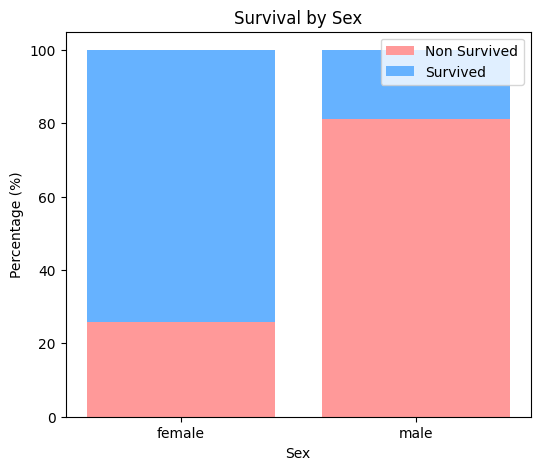

In [376]:
percent_df = (
    df_train.groupby("Sex")["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)

pivot_df = percent_df.pivot(index="Sex", columns="Survived", values="Percentage")

plt.figure(figsize=(6,5))
plt.bar(pivot_df.index.astype(str), pivot_df[0], label="Non Survived", color="#FF9999")
plt.bar(pivot_df.index.astype(str), pivot_df[1], bottom=pivot_df[0], label="Survived", color="#66B2FF")

plt.title("Survival by Sex")
plt.ylabel("Percentage (%)")
plt.xlabel("Sex")
plt.legend()
plt.show()

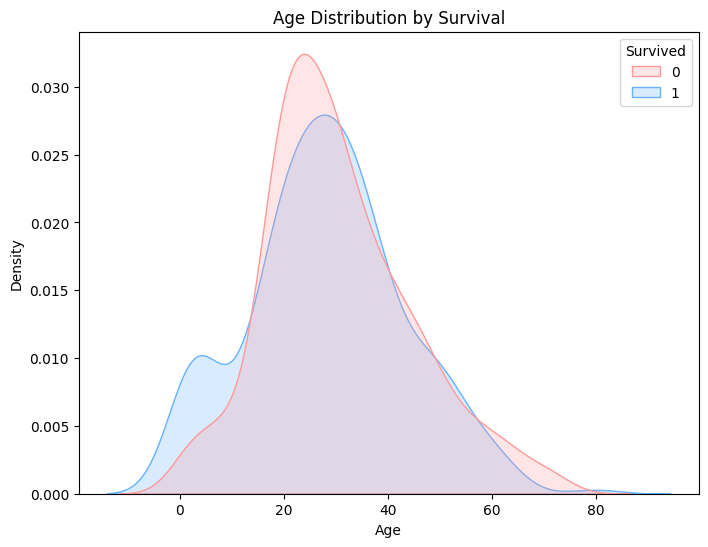

In [377]:
plt.figure(figsize=(8, 6))
sns.kdeplot(x="Age", hue="Survived", data=df_train, fill=True, common_norm=False, palette=["#FF9999", "#66B2FF"])
plt.title("Age Distribution by Survival")
plt.show()

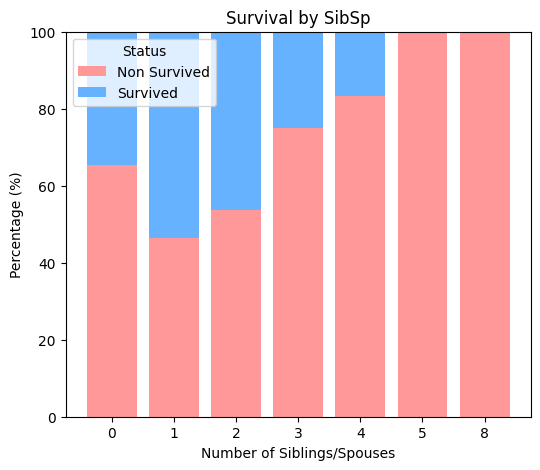

In [378]:
percent_df = (
    df_train.groupby("SibSp")["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)

pivot_df = percent_df.pivot(index="SibSp", columns="Survived", values="Percentage")

plt.figure(figsize=(6,5))
plt.bar(pivot_df.index.astype(str), pivot_df[0], label="Non Survived", color="#FF9999")
plt.bar(pivot_df.index.astype(str), pivot_df[1], bottom=pivot_df[0], label="Survived", color="#66B2FF")

plt.title("Survival by SibSp")
plt.ylabel("Percentage (%)")
plt.xlabel("Number of Siblings/Spouses")
plt.ylim(0,100)
plt.legend(title="Status")
plt.show()

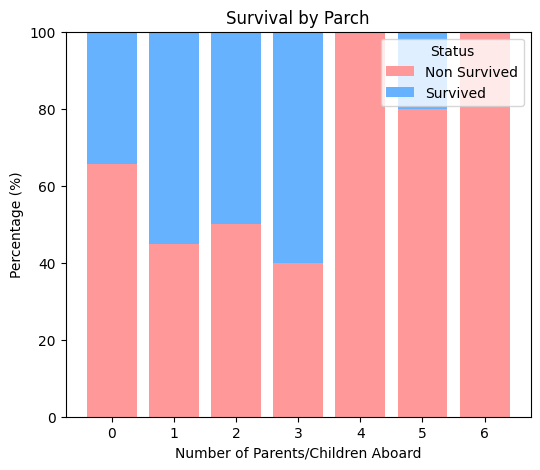

In [379]:
percent_df = (
    df_train.groupby("Parch")["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)

pivot_df = percent_df.pivot(index="Parch", columns="Survived", values="Percentage")

plt.figure(figsize=(6,5))
plt.bar(pivot_df.index.astype(str), pivot_df[0], label="Non Survived", color="#FF9999")
plt.bar(pivot_df.index.astype(str), pivot_df[1], bottom=pivot_df[0], label="Survived", color="#66B2FF")

plt.title("Survival by Parch")
plt.ylabel("Percentage (%)")
plt.xlabel("Number of Parents/Children Aboard")
plt.ylim(0,100)
plt.legend(title="Status")
plt.show()

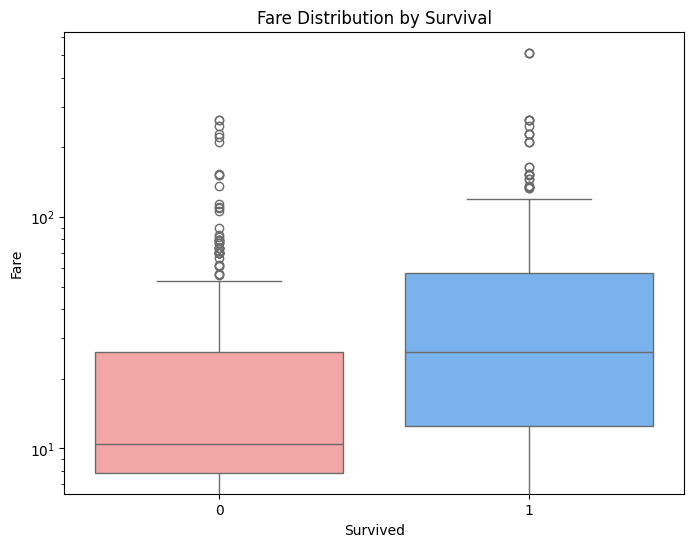

In [380]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="Survived", y="Fare", data=df_train, palette=["#FF9999", "#66B2FF"])
plt.yscale("log")  # log scale for better visualization
plt.title("Fare Distribution by Survival")
plt.show()

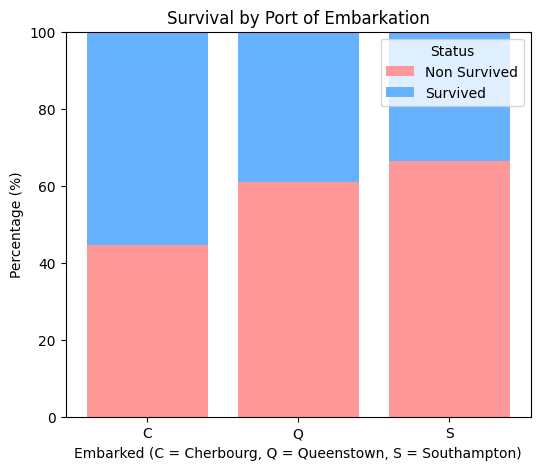

In [381]:
percent_df = (
    df_train.groupby("Embarked")["Survived"]
    .value_counts(normalize=True)
    .rename("Percentage")
    .mul(100)
    .reset_index()
)

pivot_df = percent_df.pivot(index="Embarked", columns="Survived", values="Percentage")

plt.figure(figsize=(6,5))
plt.bar(pivot_df.index.astype(str), pivot_df[0], label="Non Survived", color="#FF9999")
plt.bar(pivot_df.index.astype(str), pivot_df[1], bottom=pivot_df[0], label="Survived", color="#66B2FF")

plt.title("Survival by Port of Embarkation")
plt.ylabel("Percentage (%)")
plt.xlabel("Embarked (C = Cherbourg, Q = Queenstown, S = Southampton)")
plt.ylim(0,100)
plt.legend(title="Status")
plt.show()

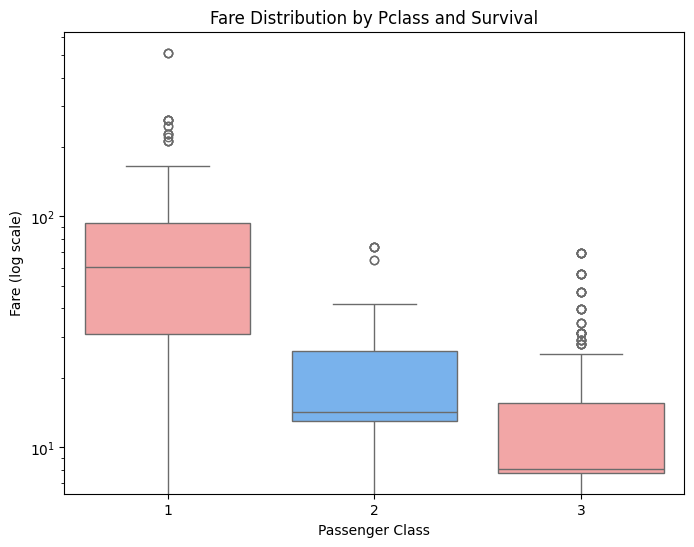

In [382]:
plt.figure(figsize=(8,6))
sns.boxplot(
    x="Pclass",
    y="Fare",
    data=df_train,
    palette=["#FF9999", "#66B2FF"]
)
plt.yscale("log")
plt.title("Fare Distribution by Pclass and Survival")
plt.ylabel("Fare (log scale)")
plt.xlabel("Passenger Class")
plt.show()


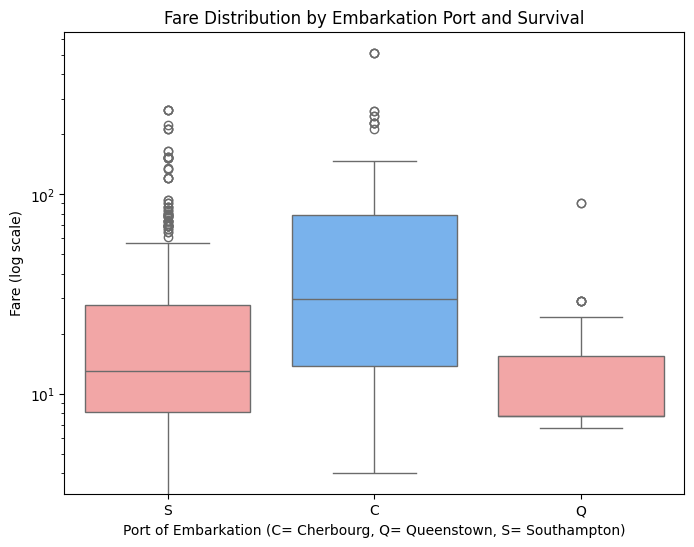

In [383]:
plt.figure(figsize=(8,6))
sns.boxplot(
    x="Embarked",
    y="Fare",
    data=df_train,
    palette=["#FF9999", "#66B2FF"]
)
plt.yscale("log")
plt.title("Fare Distribution by Embarkation Port and Survival")
plt.ylabel("Fare (log scale)")
plt.xlabel("Port of Embarkation (C= Cherbourg, Q= Queenstown, S= Southampton)")
plt.show()


## 2 Data Cleaning

### 2.1 Missing Values

In [384]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum() / len(df_train)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['# Total', '% Total'])

missing_data.head(10)

,# Total,% Total
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
PassengerId,0,0.000000
Name,0,0.000000
Pclass,0,0.000000
Survived,0,0.000000
Sex,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000


In [385]:
# 1. Drop 'Cabin' (too many missing values)
df_train = df_train.drop(columns=["Cabin"])

# 2. Impute 'Age' with the median within each group (Pclass + Sex)
df_train["Age"] = df_train.groupby(["Pclass", "Sex"])["Age"].transform(
    lambda x: x.fillna(x.median())
)

# 3. Impute 'Embarked' with the mode (most frequent value)
mode_embarked = df_train["Embarked"].mode()[0]
df_train["Embarked"] = df_train["Embarked"].fillna(mode_embarked)

# Final check: ensure no missing values remain
print(df_train.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


## 3 Feature Engineering


In [386]:
# Family size
df_train['Family size'] = df_train['SibSp'] + df_train['Parch']

# Is alone
df_train['Is alone'] = (df_train['Family size'] == 0).astype(int)

# Title extraction
df_train['Title'] = df_train['Name'].apply(
    lambda x: x.split(',')[1].split('.')[0].strip()
)
df_train['Title'] = df_train['Title'].apply(
    lambda t: t if t in ('Mr', 'Mrs', 'Miss', 'Master') else 'Other'
)

# One-hot encoding for categorical features (including Pclass)
df_train = pd.get_dummies(
    df_train,
    columns=['Sex', 'Embarked', 'Title', 'Pclass'],
    drop_first=True  # avoid collinearity
)

# Convert all boolean columns to int (0/1)
bool_cols = df_train.select_dtypes(include=['bool']).columns
df_train[bool_cols] = df_train[bool_cols].astype(int)

df_train.head()


,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Family size,Is alone,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1,0,1,0,1,0,1,0,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,1,0,0,0,0,0,0,1,0,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,0,1,1,0,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,1,0,0,0,1,0,0,1,0,0,0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,1,1,0,1,0,1,0,0,0,1


In [387]:
# Check missing values in df_test
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum() / len(df_test)).sort_values(ascending=False)
missing_data_test = pd.concat([total, percent], axis=1, keys=['# Total', '% Total'])

print(missing_data_test.head(10))

# 1. Impute Age with median per group (Pclass + Sex)
df_test["Age"] = df_test.groupby(["Pclass", "Sex"])["Age"].transform(
    lambda x: x.fillna(x.median())
)

# 2. Impute Fare with median per Pclass
df_test["Fare"] = df_test.groupby("Pclass")["Fare"].transform(
    lambda x: x.fillna(x.median())
)

# Final check: no missing values
print(df_test.isnull().sum())

             # Total   % Total
Cabin            327  0.782297
Age               86  0.205742
Fare               1  0.002392
Name               0  0.000000
Pclass             0  0.000000
PassengerId        0  0.000000
Sex                0  0.000000
Parch              0  0.000000
SibSp              0  0.000000
Ticket             0  0.000000
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [388]:
# Family size
df_test['Family size'] = df_test['SibSp'] + df_test['Parch']

# Is alone
df_test['Is alone'] = (df_test['Family size'] == 0).astype(int)

# Title extraction
df_test['Title'] = df_test['Name'].apply(
    lambda x: x.split(',')[1].split('.')[0].strip()
)
df_test['Title'] = df_test['Title'].apply(
    lambda t: t if t in ('Mr', 'Mrs', 'Miss', 'Master') else 'Other'
)

# One-hot encoding (including Pclass)
df_test = pd.get_dummies(
    df_test,
    columns=['Sex', 'Embarked', 'Title', 'Pclass'],
    drop_first=True
)

bool_cols = df_test.select_dtypes(include=['bool']).columns
df_test[bool_cols] = df_test[bool_cols].astype(int)

# --- Align columns with df_train ---
df_test = df_test.reindex(columns=df_train.columns, fill_value=0)

df_test.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Family size,Is alone,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Pclass_2,Pclass_3
0,892,0,"Kelly, Mr. James",34.5,0,0,330911,7.8292,0,1,1,1,0,0,1,0,0,0,1
1,893,0,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,1,0,0,0,1,0,0,1,0,0,1
2,894,0,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,0,1,1,1,0,0,1,0,0,1,0
3,895,0,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,0,1,1,0,1,0,1,0,0,0,1
4,896,0,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,2,0,0,0,1,0,0,1,0,0,1


## 4 Model training

In [389]:
# Define features (drop IDs and non-useful columns)
X = df_train.drop(columns=["PassengerId", "Name", "Ticket", "Survived"])

# Target
y = df_train["Survived"]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Prediction set (test dataset, no target)
X_pred = df_test.drop(columns=["PassengerId", "Name", "Ticket"])

# Results dataframe for model evaluation
df_results = pd.DataFrame(columns=["Model", "f1", "precision", "recall", "accuracy"])

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Final feature set:", X_train.columns.tolist())


Final feature set: ['Age', 'SibSp', 'Parch', 'Fare', 'Family size', 'Is alone', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other', 'Pclass_2', 'Pclass_3']


In [390]:
X.head()

,Age,SibSp,Parch,Fare,Family size,Is alone,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Pclass_2,Pclass_3
0,22.0,1,0,7.2500,1,0,1,0,1,0,1,0,0,0,1
1,38.0,1,0,71.2833,1,0,0,0,0,0,0,1,0,0,0
2,26.0,0,0,7.9250,0,1,0,0,1,1,0,0,0,0,1
3,35.0,1,0,53.1000,1,0,0,0,1,0,0,1,0,0,0
4,35.0,0,0,8.0500,0,1,1,0,1,0,1,0,0,0,1


### 4.1 Linear Regression

In [394]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# --- 1. Linear Regression as classifier ---
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions (continuous values)
y_pred_cont = lin_reg.predict(X_val)

# Apply threshold 0.5 to turn into binary classification
y_pred = (y_pred_cont >= 0.5).astype(int)

# Evaluate
print("Linear Regression")
print("Accuracy :", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall   :", recall_score(y_val, y_pred))
print("F1       :", f1_score(y_val, y_pred))

# --- 2. Ridge Regression (L2 regularization) ---
ridge = Ridge(alpha=1.0)   # you can try different alphas
ridge.fit(X_train, y_train)
y_pred_ridge = (ridge.predict(X_val) >= 0.5).astype(int)

print("\nRidge Regression")
print("Accuracy :", accuracy_score(y_val, y_pred_ridge))
print("Precision:", precision_score(y_val, y_pred_ridge))
print("Recall   :", recall_score(y_val, y_pred_ridge))
print("F1       :", f1_score(y_val, y_pred_ridge))

# --- 3. Lasso Regression (L1 regularization) ---
lasso = Lasso(alpha=0.01)   # try smaller alpha for Lasso to converge
lasso.fit(X_train, y_train)
y_pred_lasso = (lasso.predict(X_val) >= 0.5).astype(int)

print("\nLasso Regression")
print("Accuracy :", accuracy_score(y_val, y_pred_lasso))
print("Precision:", precision_score(y_val, y_pred_lasso))
print("Recall   :", recall_score(y_val, y_pred_lasso))
print("F1       :", f1_score(y_val, y_pred_lasso))


Linear Regression
Accuracy : 0.45
Precision: 0.4861111111111111
Recall   : 0.660377358490566
F1       : 0.56

Ridge Regression
Accuracy : 0.45
Precision: 0.4861111111111111
Recall   : 0.660377358490566
F1       : 0.56

Lasso Regression
Accuracy : 0.53
Precision: 0.53
Recall   : 1.0
F1       : 0.6928104575163399


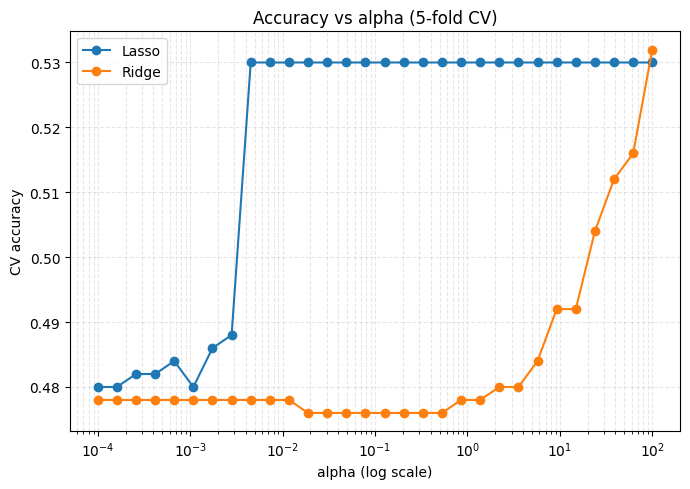

Best Ridge alpha: 100 | Acc: 0.5320
Best Lasso alpha: 0.0045204 | Acc: 0.5300
  feature  ridge_coef  lasso_coef
4      x4    0.023695    0.025562
3      x3   -0.016566   -0.000571
2      x2   -0.015804   -0.000000
8      x8    0.013872    0.000000
5      x5    0.010106    0.000000
9      x9    0.008685    0.000000
1      x1   -0.007066   -0.000000
0      x0    0.004628    0.000000
7      x7    0.002299    0.000000
6      x6   -0.001629   -0.000000


<Figure size 800x600 with 0 Axes>

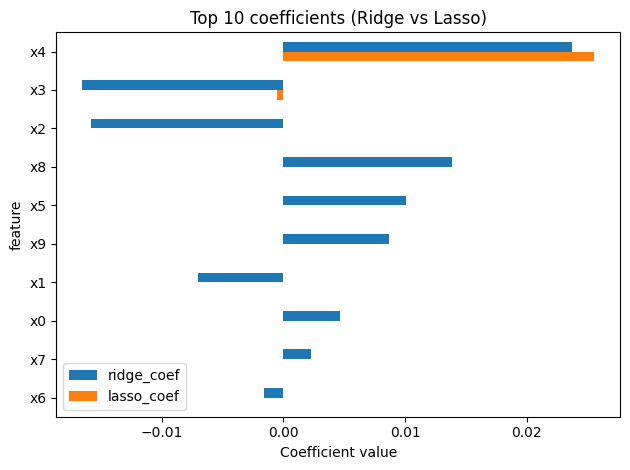

In [398]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# helpers ------------------------------------------------------------
def _to_numpy(a):
    return a.values if hasattr(a, "values") else np.asarray(a)

def _get_feature_names(X):
    return list(X.columns) if hasattr(X, "columns") else [f"x{i}" for i in range(_to_numpy(X).shape[1])]

def cv_accuracy_vs_alpha(model_cls, alphas, X, y, n_splits=5, random_state=42):
    Xn, yn = _to_numpy(X), _to_numpy(y).ravel()
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rows = []
    for a in alphas:
        fold_acc = []
        for tr_idx, va_idx in cv.split(Xn, yn):
            X_tr, X_va = Xn[tr_idx], Xn[va_idx]
            y_tr, y_va = yn[tr_idx], yn[va_idx]
            model = model_cls(alpha=a) if model_cls is not LinearRegression else model_cls()
            model.fit(X_tr, y_tr)
            y_hat = (model.predict(X_va) >= 0.5).astype(int)
            fold_acc.append(accuracy_score(y_va, y_hat))
        rows.append({"alpha": a, "accuracy": float(np.mean(fold_acc))})
    return pd.DataFrame(rows)

# main ---------------------------------------------------------------
X_all, y_all = X, y
alphas = np.logspace(-4, 2, 30)

ridge_df = cv_accuracy_vs_alpha(Ridge, alphas, X_all, y_all)
lasso_df = cv_accuracy_vs_alpha(Lasso, alphas, X_all, y_all)

results_df = pd.concat([
    ridge_df.assign(model="Ridge"),
    lasso_df.assign(model="Lasso")
], ignore_index=True)

plt.figure(figsize=(7,5))
for m, df in results_df.groupby("model"):
    df = df.sort_values("alpha")
    plt.semilogx(df["alpha"], df["accuracy"], marker="o", label=m)
plt.xlabel("alpha (log scale)")
plt.ylabel("CV accuracy")
plt.title("Accuracy vs alpha (5-fold CV)")
plt.grid(True, which="both", linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

best_ridge_alpha = ridge_df.loc[ridge_df["accuracy"].idxmax(), "alpha"]
best_lasso_alpha = lasso_df.loc[lasso_df["accuracy"].idxmax(), "alpha"]
print(f"Best Ridge alpha: {best_ridge_alpha:.5g} | Acc: {ridge_df['accuracy'].max():.4f}")
print(f"Best Lasso alpha: {best_lasso_alpha:.5g} | Acc: {lasso_df['accuracy'].max():.4f}")

# fit finale su tutto il train con i migliori alpha
Xn, yn = _to_numpy(X_all), _to_numpy(y_all).ravel()
ridge_best = Ridge(alpha=best_ridge_alpha).fit(Xn, yn)
lasso_best = Lasso(alpha=best_lasso_alpha, max_iter=20000).fit(Xn, yn)

feat_names = _get_feature_names(X_all)
coef_df = pd.DataFrame({
    "feature": feat_names,
    "ridge_coef": ridge_best.coef_,
    "lasso_coef": lasso_best.coef_,
}).sort_values("ridge_coef", key=lambda s: s.abs(), ascending=False)

print(coef_df.head(20))

# barplot coefficienti principali
top_k = min(15, len(feat_names))
plot_df = coef_df.set_index("feature").iloc[:top_k]
plt.figure(figsize=(8,6))
plot_df[["ridge_coef","lasso_coef"]].plot(kind="barh")
plt.gca().invert_yaxis()
plt.title(f"Top {top_k} coefficients (Ridge vs Lasso)")
plt.xlabel("Coefficient value")
plt.tight_layout()
plt.show()


### 4.2 Naive Bayes

                      Model  accuracy  precision    recall        f1
0   BernoulliNB (alpha=1.0)     0.530   0.530000  1.000000  0.692810
1  BernoulliNB (alpha=0.01)     0.530   0.530000  1.000000  0.692810
2                GaussianNB     0.484   0.510598  0.667925  0.577985


TypeError: 'value' must be an instance of str or bytes, not a float

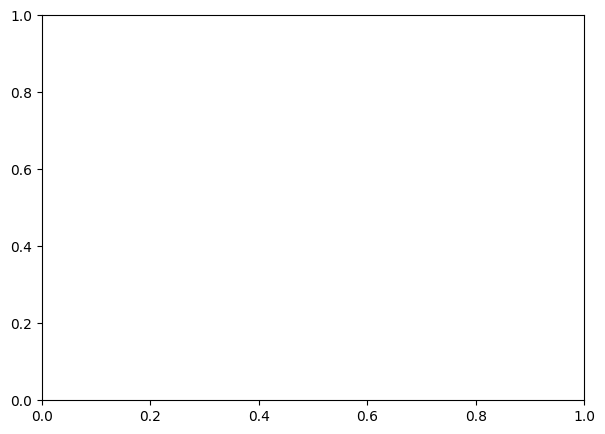

In [401]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- Ensure X is a DataFrame with column names ---
# (Se X è già un DataFrame, questa riga non cambia nulla)
X = pd.DataFrame(X, columns=X.columns if hasattr(X, "columns") else [f"x{i}" for i in range(np.asarray(X).shape[1])])
y = pd.Series(y, name="Survived")

# Continuous columns to binarize for BernoulliNB (use only those that exist)
cont_cols = [c for c in ["Age", "Fare", "SibSp", "Parch", "Family size"] if c in X.columns]
bin_cols  = [c for c in X.columns if c not in cont_cols]  # dummies (0/1) already

# Preprocess: 2 quantile bins -> {0,1} for continuous; passthrough for the rest
bern_pre = ColumnTransformer(
    transformers=[
        ("bin_cont", KBinsDiscretizer(n_bins=2, encode="ordinal", strategy="quantile"), cont_cols),
        ("pass_bin", "passthrough", bin_cols),
    ],
    remainder="drop"
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_eval(pipe, X, y, cv):
    metrics = {"accuracy": [], "precision": [], "recall": [], "f1": []}
    for tr, va in cv.split(X, y):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]
        pipe.fit(X_tr, y_tr)
        y_hat = pipe.predict(X_va)
        metrics["accuracy"].append(accuracy_score(y_va, y_hat))
        metrics["precision"].append(precision_score(y_va, y_hat))
        metrics["recall"].append(recall_score(y_va, y_hat))
        metrics["f1"].append(f1_score(y_va, y_hat))
    return {m: float(np.mean(v)) for m, v in metrics.items()}

rows = []

# BernoulliNB: try two alphas
for a in [1.0, 0.01]:
    bern_pipe = Pipeline([
        ("prep", bern_pre),
        ("clf", BernoulliNB(alpha=a))
    ])
    s = cv_eval(bern_pipe, X, y, cv)
    rows.append({"Model": f"BernoulliNB (alpha={a})", **s})

# GaussianNB (no Laplace alpha)
gauss_pipe = Pipeline([("identity", "passthrough"), ("clf", GaussianNB())])
s = cv_eval(gauss_pipe, X, y, cv)
rows.append({"Model": "GaussianNB", **s})

nb_results = pd.DataFrame(rows)
print(nb_results)

# Se stai usando df_results globale, aggiungo
try:
    df_results = pd.concat([df_results, nb_results], ignore_index=True)
except NameError:
    df_results = nb_results.copy()

# --- Plot confronto (accuracy e f1) ---
plt.figure(figsize=(7,5))
x = np.arange(len(df_results))
plt.plot(df_results["Model"], df_results["accuracy"], marker="o", label="Accuracy")
plt.plot(df_results["Model"], df_results["f1"], marker="o", label="F1")
plt.xticks(rotation=15)
plt.ylabel("Score")
plt.title("Naive Bayes: CV performance")
plt.grid(True, alpha=0.3, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()

# --- Fit finale del migliore BernoulliNB e log-odds per feature (con nomi) ---
bern_best_alpha = max(
    [r for r in rows if r["Model"].startswith("BernoulliNB")],
    key=lambda d: d["accuracy"]
)["Model"].split("alpha=")[1].rstrip(")")

bern_best = Pipeline([("prep", bern_pre), ("clf", BernoulliNB(alpha=float(bern_best_alpha)))])
bern_best.fit(X, y)

# Nomi feature in output del ColumnTransformer: con 2 bin e encode='ordinal' rimane 1 col/feature continua
bern_feature_names = cont_cols + bin_cols

# Log-odds: log P(x=1|y=1) - log P(x=1|y=0)
log_odds = bern_best.named_steps["clf"].feature_log_prob_[1] - bern_best.named_steps["clf"].feature_log_prob_[0]
coef_bern = pd.Series(log_odds, index=bern_feature_names).sort_values(key=lambda s: s.abs(), ascending=False)

print("\nTop BernoulliNB log-odds features:")
print(coef_bern.head(20))

# (opzionale) bar chart delle top-k
top_k = min(15, len(coef_bern))
plt.figure(figsize=(8,6))
coef_bern.iloc[:top_k][::-1].plot(kind="barh")
plt.title(f"Top {top_k} BernoulliNB log-odds")
plt.xlabel("log P(x=1|y=1) - log P(x=1|y=0)")
plt.tight_layout()
plt.show()


## 5 Model Evaluation

In [ ]:
df_results.sort_values(by='f1', ascending=False)

In [ ]:
df_results.set_index('Model', inplace=True)
ax = df_results.plot(kind='bar', figsize=(10, 6))

plt.title('Performance dei Modelli')
plt.xlabel('Modelli')
plt.ylabel('Punteggio')
plt.legend(title='Metriche')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
predictions_df = pd.DataFrame(predictions_xgb, columns=['Survived'])
predictions_df['PassengerId'] = df_test['PassengerId']
predictions_df.to_csv('predictions.csv', index=False)

In [ ]:
predictions_df